In [326]:
# MUST AT LEAST RUN THIS ONE TO GET THE DATA VARIABLE. OTHERS ARE OPTIONAL.
%matplotlib inline
from pyspark.sql import Row
from pyspark import SparkContext
import seaborn as sns
import re
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql.functions import col,udf, unix_timestamp
from pyspark.sql.types import DateType
from pyspark.sql.functions import udf
from pyspark.sql.types import DataType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType
import locale
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import monotonically_increasing_id
from operator import *
from pyspark.mllib.stat import Statistics
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler

data = spark.read.csv('Final Project Data_Case.csv', header=True, inferSchema=True)

# define a primary key
data = data.withColumn("id", monotonically_increasing_id())
# fix column names
for column in data.columns:
    data = data.withColumnRenamed(column, column.lower().replace(' ','_'))
data.persist(pyspark.StorageLevel.MEMORY_ONLY)


DataFrame[age: int, female: int, flu_season: int, ed_admit: int, severity_score: int, comorbidity_score: int, readmit30: int, id: bigint]

In [305]:
x = data.describe()
x = x.withColumn('age', x.age.substr(0,5))
x = x.withColumn('female', x.female.substr(0,5))
x = x.withColumn('flu_season', x.flu_season.substr(0,5))
x = x.withColumn('ed_admit', x.ed_admit.substr(0,5))
x = x.withColumn('severity_score', x['severity_score'].substr(0,5))
x = x.withColumn('comorbidity_score', x['comorbidity_score'].substr(0,5))
x = x.withColumn('readmit30', x['readmit30'].substr(0,5))
x.show()

+-------+-----+------+----------+--------+--------------+-----------------+---------+------------------+
|summary|  age|female|flu_season|ed_admit|severity_score|comorbidity_score|readmit30|                id|
+-------+-----+------+----------+--------+--------------+-----------------+---------+------------------+
|  count| 4382|  4382|      4382|    4382|          4382|             4382|     4382|              4382|
|   mean|76.84| 0.469|     0.408|   0.809|         22.35|            94.73|    0.227|            2190.5|
| stddev|7.904| 0.499|     0.491|   0.392|         18.00|            57.14|    0.419|1265.1187691280215|
|    min|   65|     0|         0|       0|             1|                1|        0|                 0|
|    max|  105|     1|         1|       1|           112|              322|        1|              4381|
+-------+-----+------+----------+--------+--------------+-----------------+---------+------------------+



In [306]:
# sns.pairplot(data.toPandas())

# Distributions overall

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121e37278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12216b0b8>]], dtype=object)

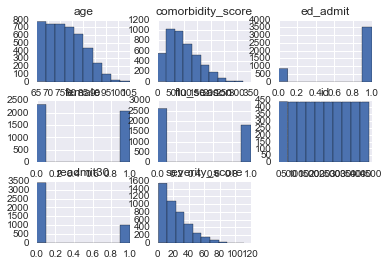

In [307]:
x = data.toPandas()
x.hist()

Distributions
Age - as expected
Cormoribidity score - as expected.
ed admit - shows our problem
female - males are disportionatly represented according to population distribution
flu_season - exceptionally high given that it is 4 months of the year
severity score - good difference in distribution


"Women make up a significant majority of the older population; the female share increases with age." Figure 28 shows that there are 58 males for every 100 females at 80 yrs old.
http://www.un.org/esa/population/publications/worldageing19502050/pdf/90chapteriv.pdf

graph of flu season
https://www.cdc.gov/flu/about/season/flu-season.htm


In [308]:
x = data.describe()
x = x.withColumn('age', x.age.substr(0,5))
x = x.withColumn('female', x.female.substr(0,5))
x = x.withColumn('flu_season', x.flu_season.substr(0,5))
x = x.withColumn('ed_admit', x.ed_admit.substr(0,5))
x = x.withColumn('severity_score', x['severity_score'].substr(0,5))
x = x.withColumn('comorbidity_score', x['comorbidity_score'].substr(0,5))
x = x.withColumn('readmit30', x['readmit30'].substr(0,5))
x.show()

+-------+-----+------+----------+--------+--------------+-----------------+---------+------------------+
|summary|  age|female|flu_season|ed_admit|severity_score|comorbidity_score|readmit30|                id|
+-------+-----+------+----------+--------+--------------+-----------------+---------+------------------+
|  count| 4382|  4382|      4382|    4382|          4382|             4382|     4382|              4382|
|   mean|76.84| 0.469|     0.408|   0.809|         22.35|            94.73|    0.227|            2190.5|
| stddev|7.904| 0.499|     0.491|   0.392|         18.00|            57.14|    0.419|1265.1187691280215|
|    min|   65|     0|         0|       0|             1|                1|        0|                 0|
|    max|  105|     1|         1|       1|           112|              322|        1|              4381|
+-------+-----+------+----------+--------+--------------+-----------------+---------+------------------+



# Distributions for not readmitted patients 

,age,female,flu_season,ed_admit,severity_score,comorbidity_score,readmit30,id
count,3384.000000,3384.000000,3384.000000,3384.000000,3384.000000,3384.000000,3384.0,3384.000000
mean,76.407506,0.457742,0.375591,0.797577,19.899823,82.849586,0.0,2188.880024
std,7.791228,0.498285,0.484347,0.401865,16.388527,50.307104,0.0,1267.202072
min,65.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000
25%,70.000000,0.000000,0.000000,1.000000,6.000000,46.000000,0.0,1088.750000
50%,76.000000,0.000000,0.000000,1.000000,17.000000,75.000000,0.0,2183.500000
75%,82.000000,1.000000,1.000000,1.000000,29.000000,114.000000,0.0,3293.250000
max,105.000000,1.000000,1.000000,1.000000,100.000000,309.000000,0.0,4381.000000


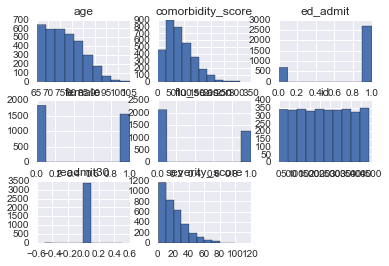

In [309]:
x = data.where(data.readmit30 == 0).toPandas()
x.hist()
x.describe()

# Distributions for readmitted patients

,age,female,flu_season,ed_admit,severity_score,comorbidity_score,readmit30,id
count,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.0,998.000000
mean,78.338677,0.508016,0.518036,0.848697,30.672345,135.038076,1.0,2195.992986
std,8.107077,0.500186,0.499925,0.358523,20.579027,60.469747,0.0,1258.646377
min,65.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0,1.000000
25%,72.000000,0.000000,0.000000,1.000000,16.000000,87.000000,1.0,1134.750000
50%,78.000000,1.000000,1.000000,1.000000,28.000000,134.000000,1.0,2209.000000
75%,84.000000,1.000000,1.000000,1.000000,44.000000,178.000000,1.0,3266.000000
max,102.000000,1.000000,1.000000,1.000000,112.000000,322.000000,1.0,4373.000000


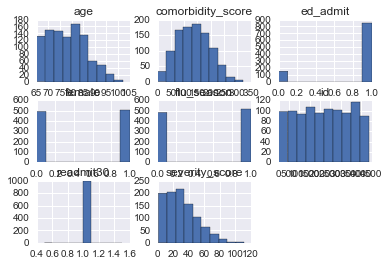

In [310]:
x = data.where(data.readmit30 == 1).toPandas()
x.hist()
x.describe()

# Distribution of not readmitted vs readmitted

In [311]:
def reassignSchema(df):
    for n,column in enumerate(data.schema):
        q = df[column.name]
        #print(q.column.name)
        df = df.withColumn(column.name, q.cast(column.dataType))
    #define a primary key
    df = df.withColumn("id", monotonically_increasing_id())
    return df
def subtractRow1ByRow2(row1, row2):
    #Row.fromSeq(s.split(",").zipWithIndex.collect{case (a,b) if n.contains(b) => a}.toSeq)
    r = Row()
    for key in row1:
        r[key] = '1'
    return Row(*r)
x = data.where(data.readmit30 == 0).describe()
y = data.where(data.readmit30 == 1).describe()
x = reassignSchema(x) # describe converts all columns to string, undo that
y = reassignSchema(y) # describe converts all columns to string, undo that
z = x.join(y, on=x.id ==y.id).select(x.summary, (x.age-y.age).alias('age'), \
                                     (x.female-y.female).alias('female'), \
                                     (x.flu_season - y.flu_season).alias('flu_season'), \
                                     (x.ed_admit - y.ed_admit).alias('ed_admit'), \
                                     (x.severity_score - y.severity_score).alias("severity_score"), \
                                     (x.comorbidity_score - y.comorbidity_score).alias('comorbidity_score'), \
                                     (x.readmit30 - y.readmit30).alias('readmit30'))
z = z.toDF('summary','age','female', 'flu_season', 'ed_admit', 'severity_score', 'comorbidity_score', 'readmit30')
difference = z
print('not readmitted')
x.show()
print('readmitted')
y.show()
print('difference')
z.show()

not readmitted
+-------+----+------+----------+--------+--------------+-----------------+---------+---+
|summary| age|female|flu_season|ed_admit|severity_score|comorbidity_score|readmit30| id|
+-------+----+------+----------+--------+--------------+-----------------+---------+---+
|  count|3384|  3384|      3384|    3384|          3384|             3384|     3384|  0|
|   mean|  76|     0|         0|       1|            20|               83|        0|  1|
| stddev|   8|     0|         0|       0|            16|               50|        0|  2|
|    min|  65|     0|         0|       0|             1|                1|        0|  3|
|    max| 105|     1|         1|       1|           100|              309|        0|  4|
+-------+----+------+----------+--------+--------------+-----------------+---------+---+

readmitted
+-------+---+------+----------+--------+--------------+-----------------+---------+---+
|summary|age|female|flu_season|ed_admit|severity_score|comorbidity_score|readmit30| 

# Analysis

In [312]:
#correlation between...
print('severity_score & comorbidity_score', data.stat.corr('severity_score', 'comorbidity_score'))
print('severity_score & readmit30', data.stat.corr('severity_score', 'readmit30'))
print('readmit30 & comorbidity_score', data.stat.corr('readmit30', 'comorbidity_score'))


severity_score & comorbidity_score 0.1967585450865839
severity_score & readmit30 0.2509424787829938
readmit30 & comorbidity_score 0.3830477827244497


In [426]:
# Naive Bayes
lpData = data.rdd.map(lambda seq: LabeledPoint(seq[-2],seq[:-3]))
train, test = lpData.randomSplit([0.7, 0.3])
model = NaiveBayes.train(train)
result = test.map(lambda x: (model.predict(x.features), x.label))
accuracy = 1.0 * result.filter(lambda x: x[0] == x[1]).count() / test.count()
print("TRAINING ACCURACY:  ", accuracy)


TRAINING ACCURACY:   0.6983154670750383
